## Global Terrorism Analysis to Predict the terrorist group responsible for a terrorist event

This notebook walks you through
<ul>
    <li><a href='#introduction'>Introduction</a></li>
    <li><a href="#missing">Dealing with missing data</a></li>
    <li><a href='#eda'>Feature Engineering</a></li>
    <li><a href="#model">Prediction</a></li>
    <ul>
        <li><a href="#linear">Linear Regression</a></li>
        <li><a href="#linearntn">Linear Regression using newton-cg solver</a></li>
        <li><a href="#dtree">Decision trees</a></li>
        <li><a href="#rforest">Random Forests</a></li>
        <li><a href="#xgb">XGBoost classifier</a></li>
        <li><a href="#fimp">Feature Importances</a></li>
    </ul>
    <li><a href="#tsne">Dimensinality reduction using TSNE</a></li>
    <ul>
        <li><a href="#tsneplot">Plot TSNE vectors using Bokeh</a></li>
    </ul>
</ul>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import xlrd
import itertools
import matplotlib.pyplot as plt
from sklearn.externals import joblib

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

<section id='introduction'></section>
## Introduction

> The GTD defines a terrorist attack as the threatened or actual use of illegal force and violence by a non-state actor to attain a political, economic, religious, or social goal through fear, coercion, or intimidation.

### Data
The terrorism data can be downloaded from <a href="http://www.start.umd.edu/gtd/contact/"> here </a>.<br>
Until 2016, __171097__ terrorist events were being recorded. Out of which __6575__ were by __Talibans__. More than __3476__ terrorist groups were created around the globe.

As described in GTD codebook, events in 1993 are approximations. During that year data is lost. So, two files are given. One contains events from 1993 and the other contains events from __1970__ to __2016__ except 1993.

### Problem
The problem is to predict the terrorist group that caused an event.

In [2]:
# Read the files and make eventid as index
events_without_93 = pd.read_excel('./globalterrorismdb_0617dist.xlsx', index_col='eventid')

events_93 = pd.read_excel('./gtd1993_0617dist.xlsx', index_col='eventid')

In [3]:
# Concatenate both the dataframes
events = pd.concat([events_without_93, events_93])
print("Total number of events: {}".format(len(events)))
print("=============================================================")
print()
print("Number of events by terrorist groups:")
print()
print(events['gname'].value_counts())

Total number of events: 171097

Number of events by terrorist groups:

Unknown                                             78508
Taliban                                              6575
Shining Path (SL)                                    4585
Islamic State of Iraq and the Levant (ISIL)          4287
Farabundo Marti National Liberation Front (FMLN)     3351
Irish Republican Army (IRA)                          2756
Al-Shabaab                                           2683
Revolutionary Armed Forces of Colombia (FARC)        2488
New People's Army (NPA)                              2414
Kurdistan Workers' Party (PKK)                       2196
Boko Haram                                           2077
Basque Fatherland and Freedom (ETA)                  2031
Communist Party of India - Maoist (CPI-Maoist)       1766
Liberation Tigers of Tamil Eelam (LTTE)              1613
National Liberation Army of Colombia (ELN)           1486
Maoists                                              1424
T

<section id='missing'></section>
## Dealing with missing data

Out of the vast number of features available, some of those are not so relavant to our problem. And for simplicity features with sentence data are not considered.

All of the data is categorical.

In [4]:
# These are the columns having sentence data or too many missing values which are not so useful
columns_to_drop = ['approxdate', 'resolution', 'summary', 'doubtterr', 'alternative', 'alternative_txt',
                   'location', 'latitude', 'longitude', 'specificity', 'weapdetail', 'individual', 'dbsource']

# related column provides eventid of other events related to this event in text format.
# This is converted to count of the related events
events['related'] = events['related'].apply(lambda x: len(x.split(',')) if type(x) == str else 0)

# These two are dropped later. 
# Though it would be useful but they are having too many values which disturb the harmony of other features
events['provstate'].fillna('Unknown', inplace=True)
events['city'].fillna('Unknown', inplace=True)

# The missing values in these columns are filled with 'unknown' corresponding to a numerical value as per the
# codeboook provided by GTD
events['attacktype2'].fillna(9, inplace=True)
events['attacktype3'].fillna(9, inplace=True)
events['weapsubtype1'].fillna(31, inplace=True)
events['weaptype2'].fillna(13, inplace=True)
events['weapsubtype2'].fillna(31, inplace=True)
events['weaptype3'].fillna(13, inplace=True)
events['weapsubtype3'].fillna(31, inplace=True)
events['weaptype4'].fillna(13, inplace=True)
events['weapsubtype4'].fillna(31, inplace=True)
events['targsubtype1'].fillna(112, inplace=True)
events['corp1'].fillna('Unknown', inplace=True)
events['target1'].fillna('Unknown', inplace=True)
events['natlty1'].fillna('500', inplace=True)
events['targtype2'].fillna(20, inplace=True)
events['targsubtype2'].fillna(112, inplace=True)
events['corp2'].fillna('Unknown', inplace=True)
events['target2'].fillna('Unknown', inplace=True)
events['natlty2'].fillna('500', inplace=True)
events['targtype3'].fillna(20, inplace=True)
events['targsubtype3'].fillna(112, inplace=True)
events['corp3'].fillna('Unknown', inplace=True)
events['target3'].fillna('Unknown', inplace=True)
events['natlty3'].fillna('500', inplace=True)
events['ishostkid'].fillna(-9, inplace=True)
events['ransom'].fillna(-9, inplace=True)

# Drop the columns in columns_to_drop list we created above
events.drop(columns_to_drop, axis=1, inplace=True)

# Drop null columns. This step eliminates all other features as well which we do not need
events.dropna(axis=1, inplace=True)

# Drop null rows to make sure we have no more null values after filling the missing values
events.dropna(inplace=True)

# Finally drop duplicate rows by keeping the first duplicate
events.drop_duplicates(keep='first', inplace=True)

# Also groups with 'Unknown' value is meaningless. So drop those rows
events.drop(events[events['gname']=='Unknown'].index, axis=0, inplace=True)
print('Total number of events after handling missing data: {}'.format(len(events)))

# Now get the value counts and convert it to a dataframe
groups = events['gname'].value_counts().to_dict()
groupsdf = pd.DataFrame.from_dict(groups, orient='index')
groupsdf.reset_index(inplace=True)
groupsdf.columns = ['group', '#events']

print("Number of groups with events more than 500: {}".format(len(groupsdf[groupsdf['#events'] > 500])))

Total number of events after handling missing data: 85561
Number of groups with events more than 2000: 27


Drop the groups having less than 500 events to reduce model complexity i.e. reduces the number of classes.

In [5]:
# Make the groups less than 500 to 'Other', so that it will be easy to drop
# Using dictionary makes mapping to a dataframe easier
groupsdf.loc[groupsdf['#events'] < 500, 'group'] = 'Other'
groupsdf = groupsdf.groupby('group').sum()
renamed_groups = groupsdf.to_dict()['#events']
print("After renaming to 'Other'")
print(renamed_groups)

After renaming to 'Other'
{'Other': 38148, 'Muslim extremists': 537, 'Boko Haram': 1982, 'Al-Shabaab': 2642, 'Shining Path (SL)': 3795, "Donetsk People's Republic": 544, 'Communist Party of India - Maoist (CPI-Maoist)': 1734, 'Revolutionary Armed Forces of Colombia (FARC)': 2372, 'Farabundo Marti National Liberation Front (FMLN)': 2502, 'Basque Fatherland and Freedom (ETA)': 1910, 'M-19 (Movement of April 19)': 512, 'Houthi extremists (Ansar Allah)': 843, 'Tehrik-i-Taliban Pakistan (TTP)': 1236, 'Al-Qaida in Iraq': 576, "New People's Army (NPA)": 2341, 'Irish Republican Army (IRA)': 2544, 'Nicaraguan Democratic Force (FDN)': 862, 'Sikh Extremists': 666, 'Palestinians': 1116, 'Islamic State of Iraq and the Levant (ISIL)': 3757, 'Al-Qaida in the Arabian Peninsula (AQAP)': 956, 'Manuel Rodriguez Patriotic Front (FPMR)': 655, 'African National Congress (South Africa)': 596, 'Liberation Tigers of Tamil Eelam (LTTE)': 1579, 'Taliban': 6316, "Kurdistan Workers' Party (PKK)": 2108, 'Maoists': 

In [6]:
renamed_groups.pop('Other')
print("After popping out 'Other'")
print(renamed_groups)

After popping out 'Other'
{'Muslim extremists': 537, 'Boko Haram': 1982, 'Al-Shabaab': 2642, 'Shining Path (SL)': 3795, "Donetsk People's Republic": 544, 'Communist Party of India - Maoist (CPI-Maoist)': 1734, 'Revolutionary Armed Forces of Colombia (FARC)': 2372, 'Farabundo Marti National Liberation Front (FMLN)': 2502, 'Basque Fatherland and Freedom (ETA)': 1910, 'M-19 (Movement of April 19)': 512, 'Houthi extremists (Ansar Allah)': 843, 'Tehrik-i-Taliban Pakistan (TTP)': 1236, 'Al-Qaida in Iraq': 576, "New People's Army (NPA)": 2341, 'Irish Republican Army (IRA)': 2544, 'Nicaraguan Democratic Force (FDN)': 862, 'Sikh Extremists': 666, 'Palestinians': 1116, 'Islamic State of Iraq and the Levant (ISIL)': 3757, 'Al-Qaida in the Arabian Peninsula (AQAP)': 956, 'Manuel Rodriguez Patriotic Front (FPMR)': 655, 'African National Congress (South Africa)': 596, 'Liberation Tigers of Tamil Eelam (LTTE)': 1579, 'Taliban': 6316, "Kurdistan Workers' Party (PKK)": 2108, 'Maoists': 1395, 'National 

In [7]:
# Map the dictionary to dataframe. If present in our dict keep it else make it NaN
events['gname'] = events['gname'].apply(lambda x: x if x in renamed_groups else np.NaN)
events.dropna(axis=0, inplace=True)
print("Total number of events after dropping geoups less than 2000 events: {}".format(len(events)))

Total number of events after dropping geoups less than 2000 events: 47413


In [8]:
# Drop other text columns and create a new dataframe used for later analysis
text_columns = ['country_txt', 'region_txt', 'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt']
data = events.drop(text_columns, axis=1)

<section id='eda'></section>
## Feature Engineering

The heatmap shows correlation between features. From this we cannot come to a conclusion to keep or drop features as every feature is correlated in someway. But this gives a very good idea of strongly correlated or weakly correlated features.

For example iyear and ransom are strongly negatively correlated with around -0.8 correlation.

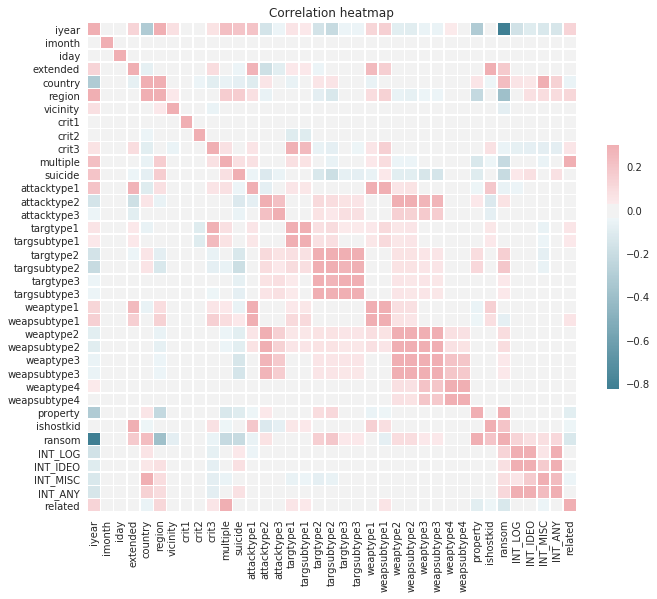

In [9]:
sns.set(style="white")


# Compute the correlation matrix
corr = data.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation heatmap')
plt.show()

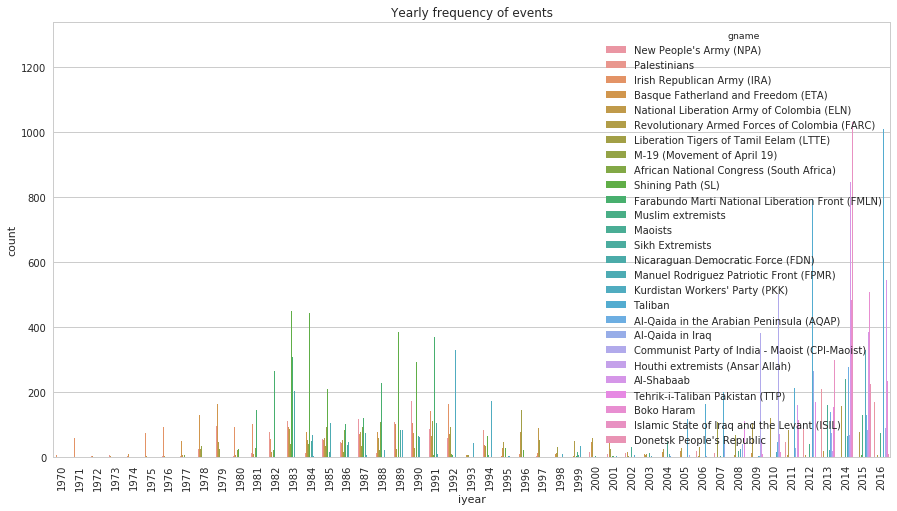

In [10]:
sns.set_style("whitegrid")
sns.countplot(x="iyear", hue="gname", data=data)
plt.xticks(rotation=90)
plt.title('Yearly frequency of events')
None

There is an increasing trend in number of events and there is some distribution among groups which means that time is a good feature. More analysis could be done for this but for simplicity this is enough.

The feature extended also differentiates groups

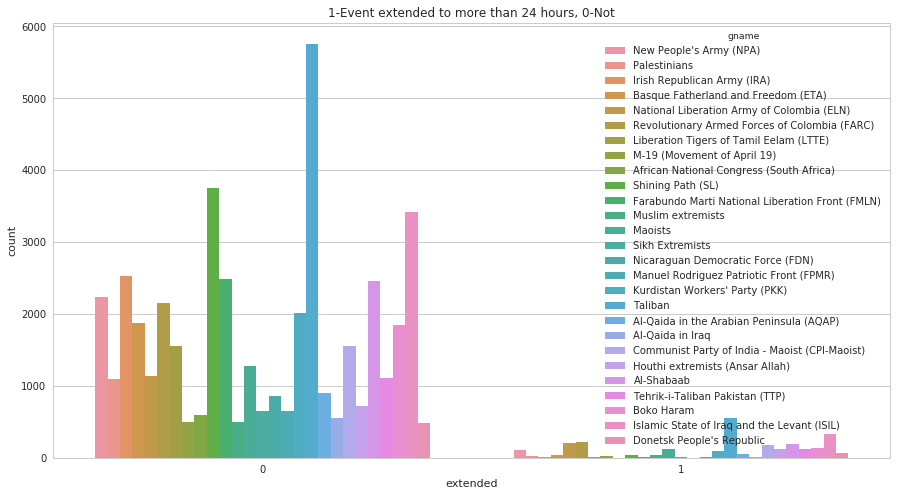

In [11]:
sns.countplot(x="extended", hue="gname", data=data)
plt.title('1-Event extended to more than 24 hours, 0-Not')
None

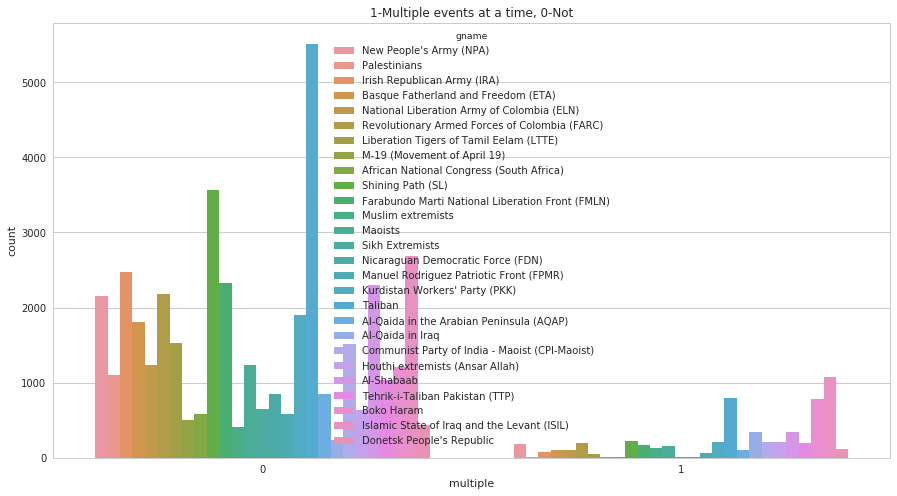

In [12]:
sns.countplot(x="multiple", hue="gname", data=data)
plt.title('1-Multiple events at a time, 0-Not')
None

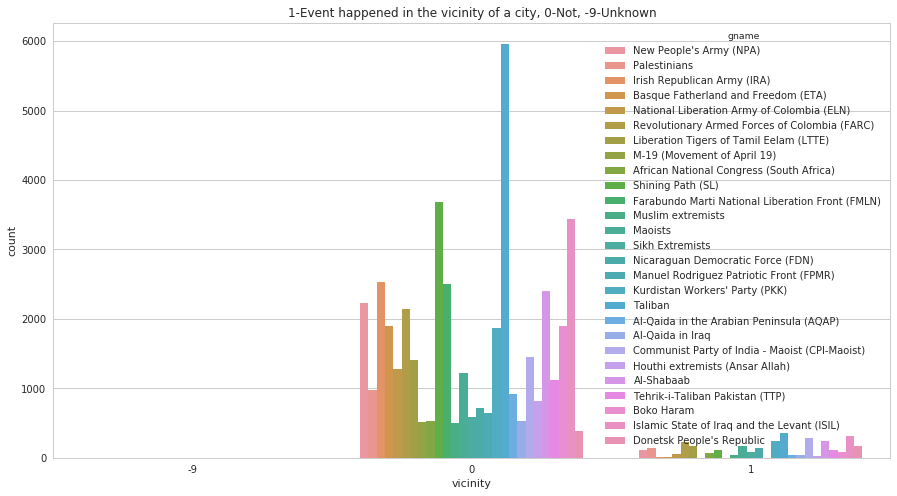

In [13]:
sns.countplot(x="vicinity", hue="gname", data=data)
plt.title('1-Event happened in the vicinity of a city, 0-Not, -9-Unknown')
None

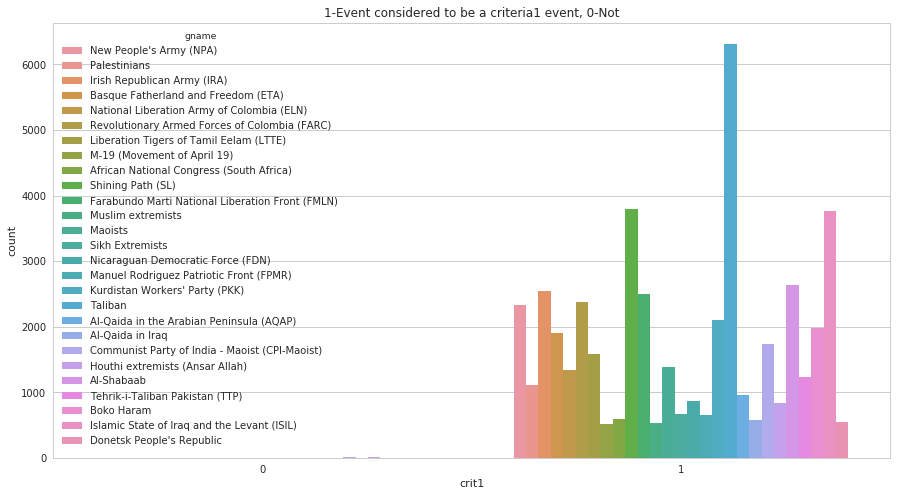

In [14]:
sns.countplot(x="crit1", hue="gname", data=data)
plt.title('1-Event considered to be a criteria1 event, 0-Not')
None

crit1 feature doesnot provide much information. It could be dropped.
crit2 is similar to crit1.

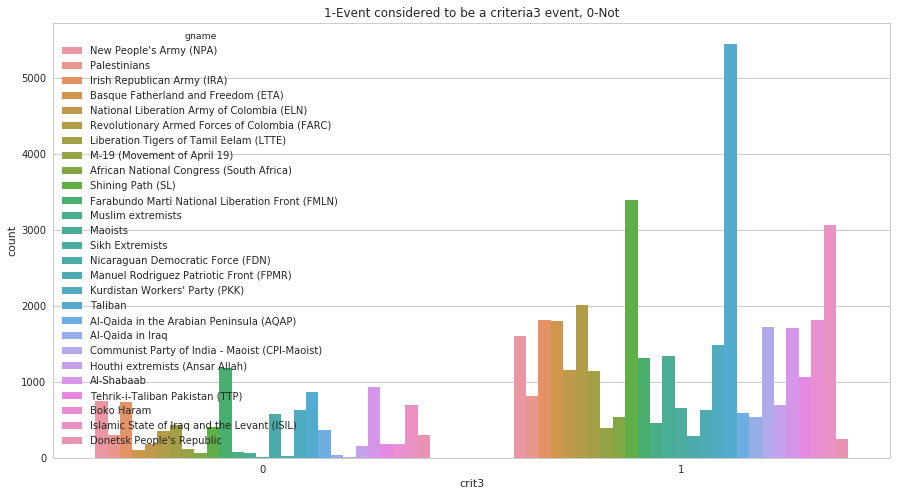

In [15]:
sns.countplot(x="crit3", hue="gname", data=data)
plt.title('1-Event considered to be a criteria3 event, 0-Not')
None

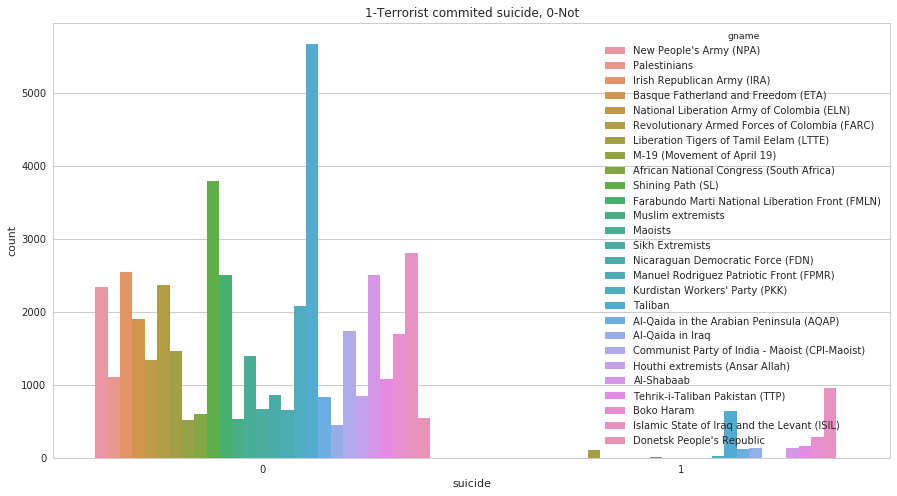

In [16]:
sns.countplot(x="suicide", hue="gname", data=data)
plt.title('1-Terrorist commited suicide, 0-Not')
None

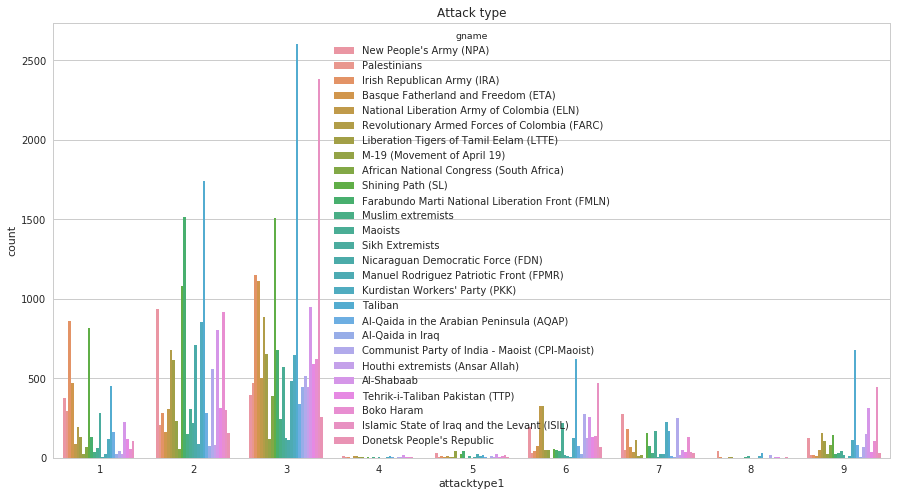

In [17]:
sns.countplot(x="attacktype1", hue="gname", data=data)
plt.title('Attack type')
None

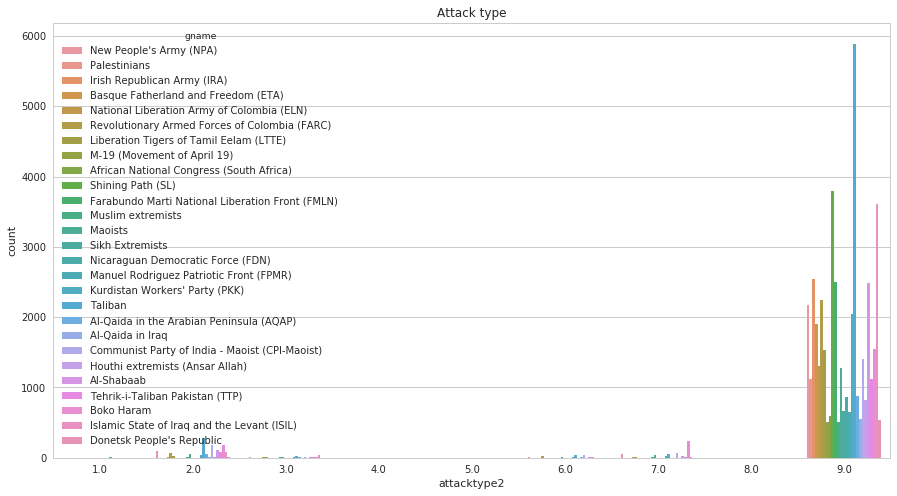

In [18]:
sns.countplot(x="attacktype2", hue="gname", data=data)
plt.title('Attack type')
None

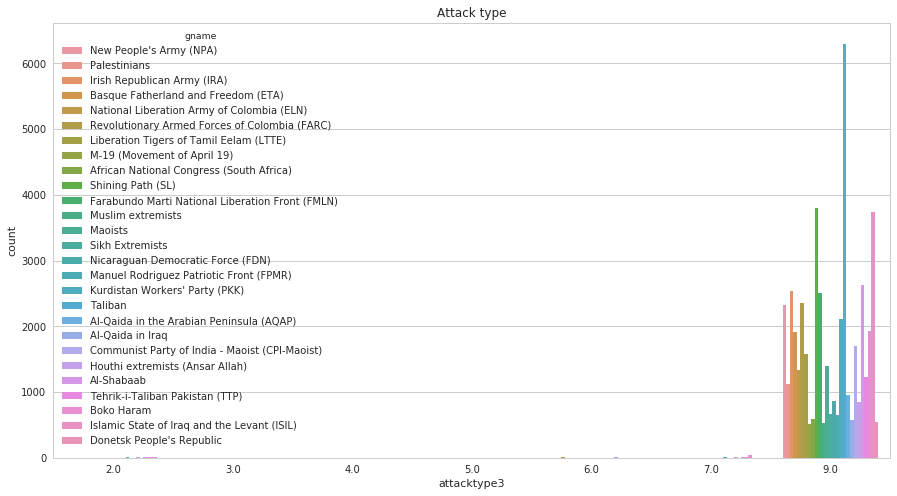

In [19]:
sns.countplot(x="attacktype3", hue="gname", data=data)
plt.title('Attack type')
None

Attack type 3 could be dropped because much information could not be fetched.

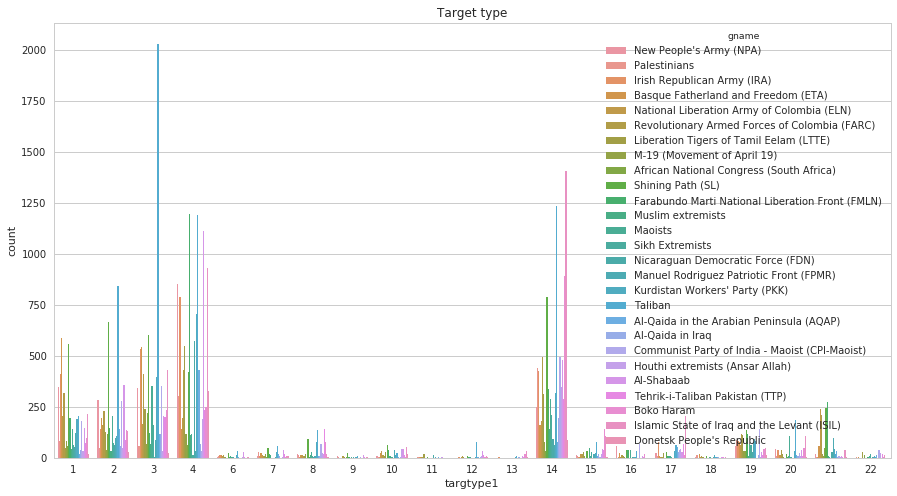

In [20]:
sns.countplot(x="targtype1", hue="gname", data=data)
plt.title('Target type')
None

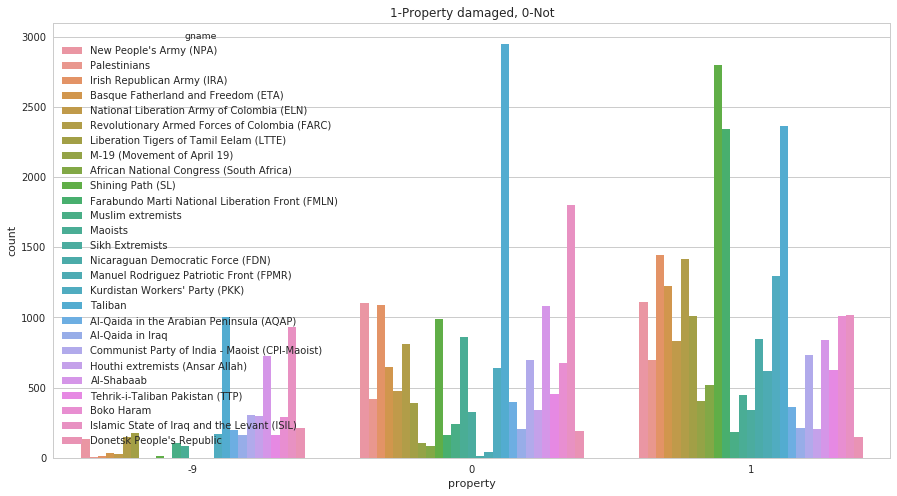

In [21]:
sns.countplot(x="property", hue="gname", data=data)
plt.title('1-Property damaged, 0-Not')
None

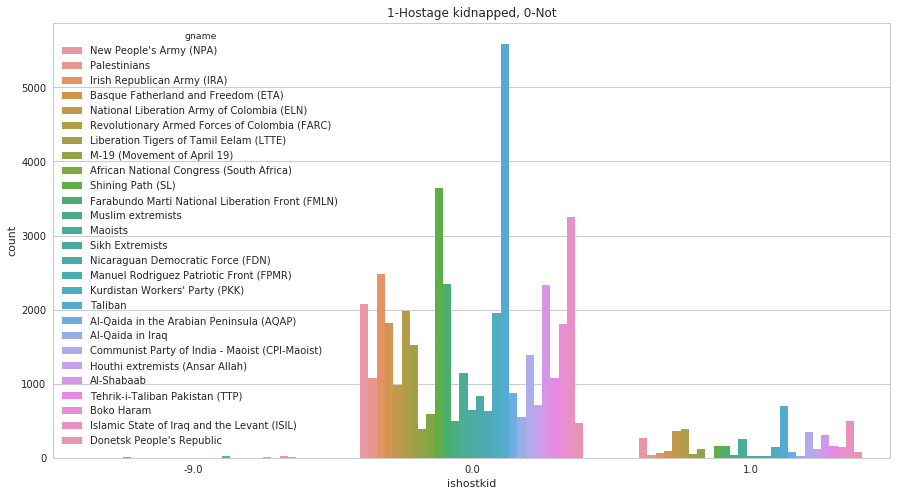

In [22]:
sns.countplot(x="ishostkid", hue="gname", data=data)
plt.title('1-Hostage kidnapped, 0-Not')
None

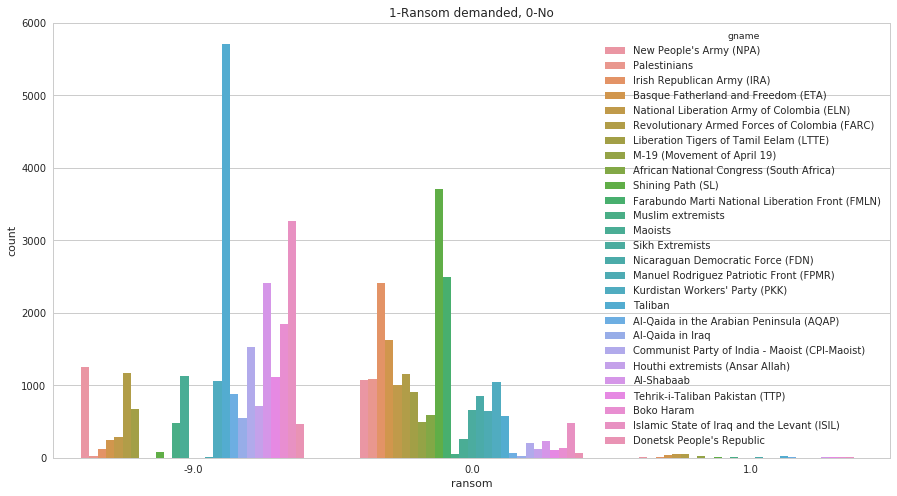

In [23]:
sns.countplot(x="ransom", hue="gname", data=data)
plt.title('1-Ransom demanded, 0-No')
None

And yet more features.....

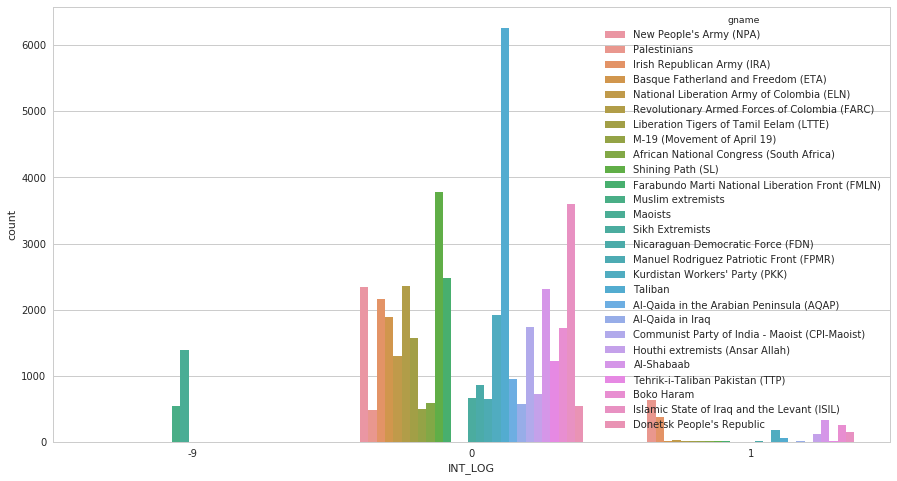

In [24]:
sns.countplot(x="INT_LOG", hue="gname", data=data)
None

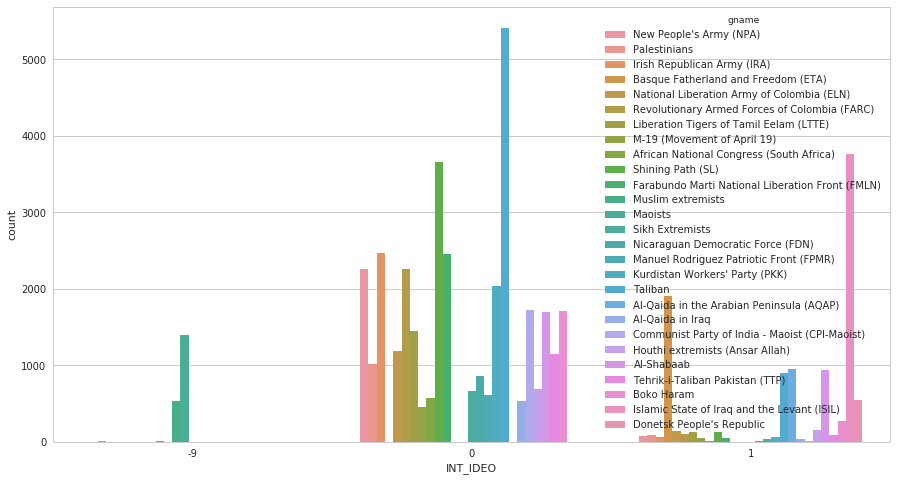

In [25]:
sns.countplot(x="INT_IDEO", hue="gname", data=data)
None

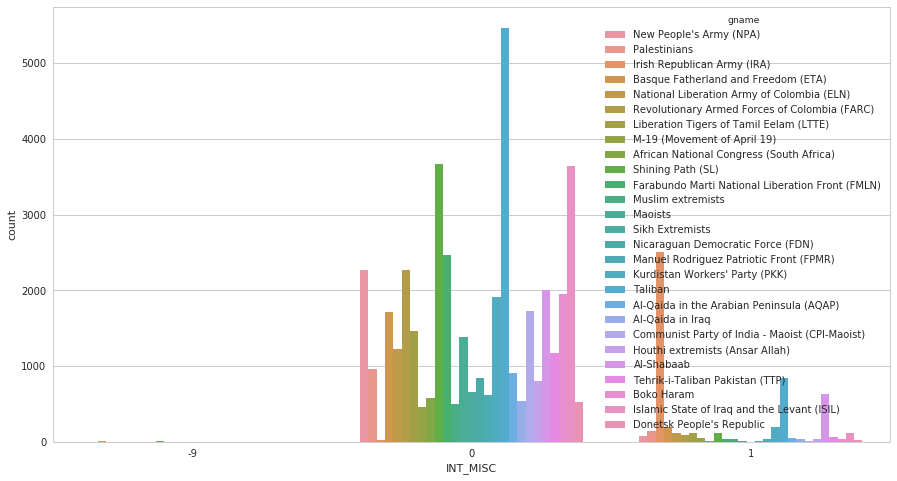

In [26]:
sns.countplot(x="INT_MISC", hue="gname", data=data)
None

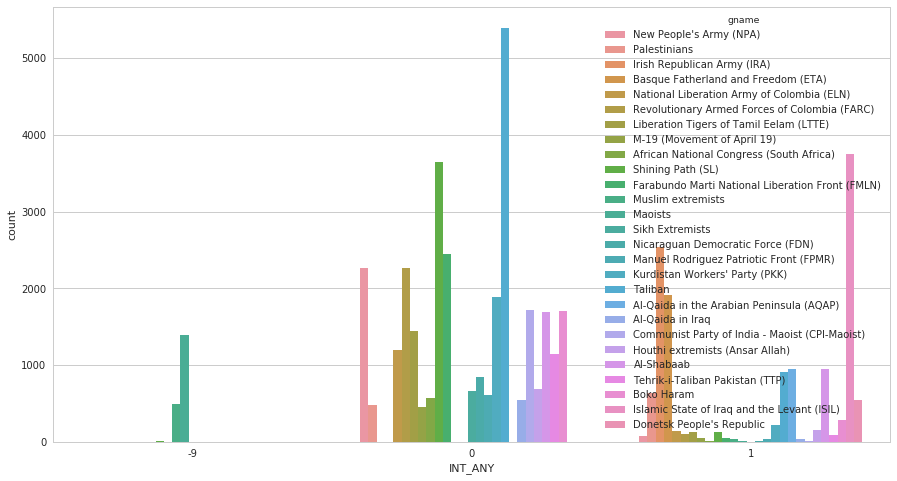

In [27]:
sns.countplot(x="INT_ANY", hue="gname", data=data)
None

In [28]:
features_drop = ['crit1', 'crit2', 'attacktype3', 'corp1', 'corp2', 'corp3', 'target1', 'target2', 
                 'target3', 'ransom', 'INT_MISC', 'INT_ANY', 'city', 'provstate']
data.drop(features_drop, axis=1, inplace=True)
print('Number of columns in final data: {}'.format(len(data.columns)))

Number of columns in final data: 35


In [29]:
data['natlty1'] = data['natlty1'].astype(int)
data['natlty2'] = data['natlty2'].astype(int)
data['natlty3'] = data['natlty3'].astype(int)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47413 entries, 197001310001 to 199312300003
Data columns (total 35 columns):
iyear           47413 non-null int64
imonth          47413 non-null int64
iday            47413 non-null int64
extended        47413 non-null int64
country         47413 non-null int64
region          47413 non-null int64
vicinity        47413 non-null int64
crit3           47413 non-null int64
multiple        47413 non-null int64
suicide         47413 non-null int64
attacktype1     47413 non-null int64
attacktype2     47413 non-null float64
targtype1       47413 non-null int64
targsubtype1    47413 non-null float64
natlty1         47413 non-null int64
targtype2       47413 non-null float64
targsubtype2    47413 non-null float64
natlty2         47413 non-null int64
targtype3       47413 non-null float64
targsubtype3    47413 non-null float64
natlty3         47413 non-null int64
gname           47413 non-null object
weaptype1       47413 non-null int64
weapsubty

<section id='model'></section>
## Prediction

In [31]:
x = data.drop(['gname'], axis=1)
y = data['gname']

In [32]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

/home/naveen/Desktop/general/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=y)

<section id="linear"></section>
### Linear Regression

In [34]:
# make the if statement true if you want to run the classifier yourself
if 1 == 0:
    lclf = LogisticRegression()
    lclf.fit(x_train, y_train)
    joblib.dump(lclf, 'lclf.pkl')
lclf = joblib.load('lclf.pkl')
preds_lclf = lclf.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, preds_lclf)))

Accuracy score: 0.7933361450864614


<section id="linearntn"></section>
### Linear Regression using newton-cg solver

In [35]:
if 1 == 0:
    clf = LogisticRegression(n_jobs=4, solver='newton-cg', max_iter=1000, multi_class='multinomial')
    clf.fit(x_train, y_train)
    joblib.dump(clf, 'lreg_newton.pkl')

clf_newton = joblib.load('lreg_newton.pkl') 
preds_ntn = clf_newton.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, preds_ntn)))

Accuracy score: 0.9382117250105441


In [36]:
print("Coefficients shape: {}".format(clf_newton.coef_.shape))

Coefficients shape: (27, 34)


<section id='dtree'></section>
## Decision trees

In [37]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(x_train, y_train)
preds_dtree = dtree.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, preds_dtree)))

Accuracy score: 0.9723745255166596


<section id='rforest'></section>
## Random Forests

In [38]:
rfrst = RandomForestClassifier(n_jobs=4, n_estimators=500, max_features='sqrt', random_state=42)
rfrst.fit(x_train, y_train)
preds_rfrst = rfrst.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, preds_rfrst)))

Accuracy score: 0.9744833403627161


<section id='xgb'></section>
## XGBoost classifier

In [39]:
if 1 == 0:
    xgbc = xgb.XGBClassifier(seed=42, n_estimators=300)
    xgbc.fit(x_train, y_train)
    joblib.dump(xgbc, 'xgbc.pkl')
xgbc = joblib.load('xgbc.pkl')
preds_xgb = xgbc.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, preds_xgb)))

Accuracy score: 0.9734289329396879


<section id='fimp'></section>
## Feature importances

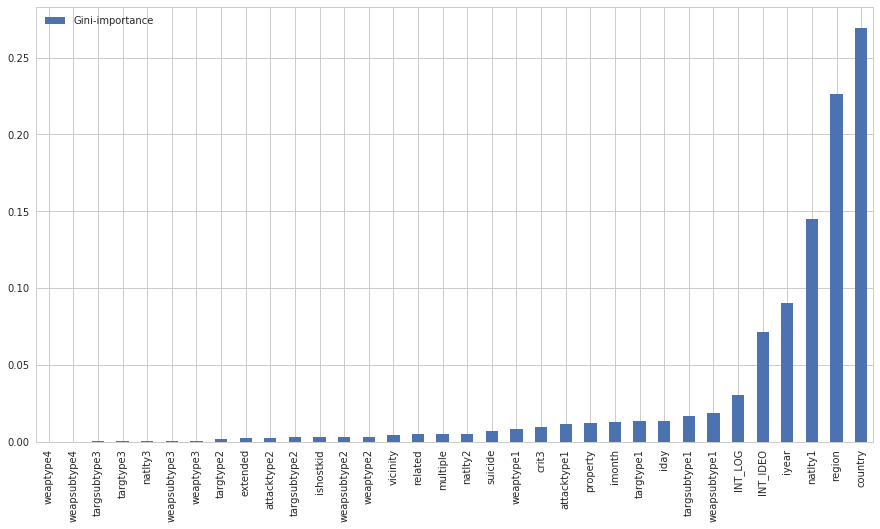

In [40]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x, y)

feats = {}
for feature, importance in zip(x.columns, forest.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
None

<section id='tsne'></section>
## Dimensionality Reduction

In [41]:
if 1 == 0:
    tsne = TSNE()
    x_embedded = tsne.fit_transform(x)

    with open('tsne_model', 'wb') as f:
        joblib.dump(tsne, f)

    pd.np.save('tsne_vectors.npy', x_embedded)

with open('tsne_model', 'rb') as f:
    tsne = joblib.load(f)
    
tsne_vectors = pd.np.load('tsne_vectors.npy')

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(x.index),
                            columns=[u'x_coord', u'y_coord'])

Now we have a two-dimensional representation of our data! Let's take a look.

In [42]:
tsne_vectors.head()

x_coord    y_coord
eventid                           
197001310001 -41.769047  -8.263063
197004020001 -42.578110  -7.352570
197004250001 -67.174561 -11.620109
197005040001 -71.196693   5.524034
197006260001  69.342499 -16.910467

In [43]:
tsne_vectors[u'group'] = data['gname']

<section id='tsneplot'></section>
### Plotting with bokeh

In [44]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [45]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@group') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

<section id="conclusion"></section>
## Conclusion
So far Random forests turned out to be better with __97.5__ accuracy in predicting among __27 classes__ which is good.<br>
An important feature in our prediction is region. Because terrorist groups target specific countries, which is again based on its motto & country where the group originated from.

### Further enhancement
The model can be further tuned by adding text features like summary, city, provstate, etc.<br>
If the model sees more data related to groups having lesser events, prediction will be improved further.<br>